# Exploration of Projection Spaces

In [1]:
# Feel free to add dependencies, but make sure that they are included in environment.yml

#disable some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

#plots the figures in place instead of a new window
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import altair as alt
from altair import datum
alt.data_transformers.disable_max_rows()

from sklearn import manifold
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
from umap import UMAP

## Data
To be able to explore paths in a projected space, you need to pick a problem/algorithm/model that consists of multiple states that change iteratively.

<details>
    <summary><a>Click to see an Example</a></summary>

    
An example is the solving of a Rubik's Cube. After each rotation the state of the cube changes. This results in a path from the initial state, through the individual rotations, to the solved cube.
By using projection, we can examine the individual states and paths in the two-dimensional space.
Depending on the initial state and the solution strategy the paths will differ or resemble each other.
    
This is an example of solving 10 randomly scrambled Rubik's Cubes with two different strategies, the Beginner (in green) and the Fridrich Method (in orange):
<div>
    <img alt="Rubiks's Cube Sovling Strategies" src="rubiks.png" width="600"/>
</div>
You can see that although each cube is scrambled differently in the beginning, both strategies converge to the same paths after a few steps.
You can also notice that the Beginner's method takes some additional paths that are not necessary with the Fridrich method.
</details>

### Read and Prepare Data
Read in your data from a file or create your own data.

Document any data processing steps.

In [2]:
from copy import copy
from wumpusworld.simplified_wumpus_world import SimplifiedWumpusWorld
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import mkdir
from os import path
from sklearn.decomposition import PCA

In [3]:
# algorithms for the wumpus

runs = 10000

def q_learning(env):
    action_space_size = env.action_space.n
    state_space_size = env.observation_space.n
    q_table = np.zeros((state_space_size, action_space_size))

    gamma = 0.99
    lr = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.1
    epsilon_decay_rate = 0.001

    total_reward = 0
    biggest_reward = -9999999
    states = []
    rewards_to_plot = np.zeros((runs, 100))

    for run in range(runs):
        state = env.reset()
        run_reward = 0
        for step in range(100):

            if np.random.uniform(0, 1) > lr:
                action = np.argmax(q_table[state, :])
            else:
                action = env.action_space.sample()

            new_state, reward, done = env.step(action)

            old_value = q_table[state, action]
            next_max = np.max(q_table[new_state])

            q_table[state, action] = old_value * (1 - lr) + lr * (reward + gamma * next_max)

            state = new_state

            run_reward += reward
            rewards_to_plot[run, step] = reward
            biggest_reward = max(biggest_reward, reward)

            x, y = env.agentX, env.agentY

            new_row_state = ["q_learning", x, y, run, step, action, reward, run_reward, total_reward, biggest_reward]
            states.append(','.join(map(str, new_row_state)))

            if done:
                break

        total_reward += run_reward
        lr = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-epsilon_decay_rate * run)

    return states, rewards_to_plot


def random(env):
    total_reward = 0
    states = []
    rewards_to_plot = np.zeros((runs, 100))

    for run in range(runs):
        env.reset()
        reward_run = 0
        biggest_reward = 0
        for step in range(100):
            action = np.random.choice(env.action_space.n)
            new_state, reward, done = env.step(action)

            biggest_reward = max(biggest_reward, reward)
            reward_run += reward
            rewards_to_plot[run, step] = reward

            x, y = env.agentX, env.agentY

            new_row_state = ["random", x, y, run, step, action, reward, reward_run, total_reward, biggest_reward]
            states.append(','.join(map(str, new_row_state)))

            if done:
                break
    return states, rewards_to_plot


def greedy(env):
    total_reward = 0
    states = []
    rewards_to_plot = np.zeros((runs, 100))

    for run in range(runs):
        env.reset()
        run_reward = 0
        biggest_reward = 0
        for step in range(100):
            rewards_ = [(cenv := copy(env)).step(direction)[1] for direction in range(4)]
            action = np.random.choice(np.argwhere(rewards_ == np.amax(rewards_)).flatten())
            next_state, reward, done = env.step(action)

            biggest_reward = max(biggest_reward, reward)
            run_reward += reward
            rewards_to_plot[run, step] = reward

            x, y = env.agentX, env.agentY

            new_row_state = ["greedy", x, y, run, step, action, reward, run_reward, total_reward, biggest_reward]
            states.append(','.join(map(str, new_row_state)))

            if done:
                break
        total_reward += run_reward

    return states, rewards_to_plot

In [4]:
env = SimplifiedWumpusWorld()

fn = f"data/wumpus/wumpus.csv"

sanity_check_rewards = []

if not path.isdir("data/wumpus"):
    mkdir("data/wumpus")

In [9]:
# generating data from running 3 different algorithms on the wumpus game

with open(fn, "w") as f:
    f.write(f"algo_name,x_agent_position,y_agent_position,run,step,action,reward,run_reward,total_reward,biggest_reward\n")
    for algo in [random, greedy, q_learning]:
        lines,rewards_to_plot = algo(env)
        f.writelines("\n".join(lines))
        f.write("\n")
        
        # save to plot them later
        sanity_check_rewards.append(rewards_to_plot)

In [5]:
df_origin = pd.read_csv(fn)
df_origin

,algo_name,x_agent_position,y_agent_position,run,step,action,reward,run_reward,total_reward,biggest_reward
0,random,0,0,0,0,1,-1,-1,0,0
1,random,0,1,0,1,0,-1,-2,0,0
2,random,0,0,0,2,1,-1,-3,0,0
3,random,0,0,0,3,1,-1,-4,0,0
4,random,0,0,0,4,1,-1,-5,0,0
...,...,...,...,...,...,...,...,...,...,...
602880,q_learning,1,1,9999,1,3,-1,-2,3913656,1000
602881,q_learning,2,1,9999,2,3,-1,-3,3913656,1000
602882,q_learning,2,2,9999,3,0,-1,-4,3913656,1000
602883,q_learning,3,2,9999,4,3,-1,-5,3913656,1000


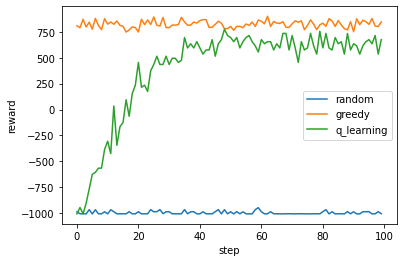

In [10]:
def sanity_check_rewards_plot(rewards_per_algos:list):
    algos = [random, greedy, q_learning]
    
    for algo_rewards in rewards_per_algos:
        rewards_per_thousand_episodes = np.split(np.array(algo_rewards), runs / 100)
        count = 100
        
        output = []
        for r in rewards_per_thousand_episodes:
            # print(f"{count: <5}: {np.sum(r / 100)}")
            output.append(np.sum(r / 100))
            count += 100

        plt.plot(output)

    plt.legend([algo.__name__ for algo in algos])
    plt.xlabel("step")
    plt.ylabel("reward")
    plt.show()


sanity_check_rewards_plot(sanity_check_rewards)    

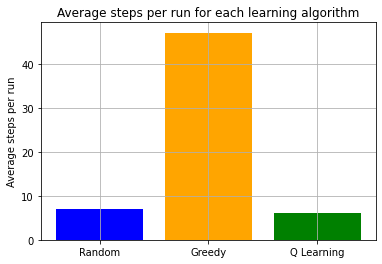

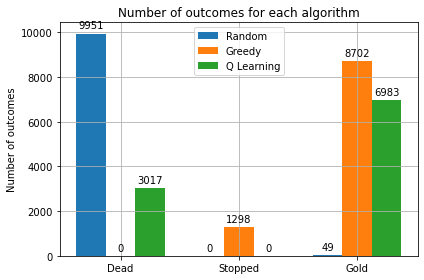

In [6]:
# success statistics for the algorithms
all_runs = df_origin['run']
runs_diff = np.diff(all_runs)
last_line_ind = np.array(np.where(runs_diff != 0))
last_line_ind = np.append(last_line_ind, len(df_origin)-1)
n_dead_random = 0
n_stop_random = 0
n_gold_random = 0
n_dead_greedy = 0
n_stop_greedy = 0
n_gold_greedy = 0
n_dead_q_learning = 0
n_stop_q_learning = 0
n_gold_q_learning = 0

for i in last_line_ind:
    act_row = df_origin.iloc[i]
    act_algo = act_row['algo_name']
    act_outcome = act_row['reward']
    #print(act_algo)
    #print(act_outcome)
    if act_algo == 'random':
        if act_outcome == -1000:
            n_dead_random += 1
        elif act_outcome == 1000:
            n_gold_random += 1
        else:
            n_stop_random += 1
    elif act_algo == 'greedy':
        if act_outcome == -1000:
            n_dead_greedy += 1
        elif act_outcome == 1000:
            n_gold_greedy += 1
        else:
            n_stop_greedy += 1
    elif act_algo == 'q_learning':
        if act_outcome == -1000:
            n_dead_q_learning += 1
        elif act_outcome == 1000:
            n_gold_q_learning += 1
        else:
            n_stop_q_learning += 1
                
average_steps_random = len(df_origin.loc[df_origin['algo_name'] == 'random']) / runs
average_steps_greedy = len(df_origin.loc[df_origin['algo_name'] == 'greedy']) / runs
average_steps_q_learning = len(df_origin.loc[df_origin['algo_name'] == 'q_learning']) / runs

plt.figure()
#plt.bar(['Random', 'Greedy', 'Q Learning'], [average_steps_random, average_steps_greedy, average_steps_q_learning], color = [[1, 0, 0],[1, 0, 1],[1, 1, 0]])
plt.bar(['Random', 'Greedy', 'Q Learning'], [average_steps_random, average_steps_greedy, average_steps_q_learning], color = ['blue','orange','green'])
#plt.xlabel('Algorithm')
plt.ylabel('Average steps per run')
plt.title('Average steps per run for each learning algorithm')
plt.grid()
plt.show()

labels = ['Dead', 'Stopped', 'Gold']
random_values = [n_dead_random, n_stop_random, n_gold_random]
greedy_values = [n_dead_greedy, n_stop_greedy, n_gold_greedy]
q_learning_values = [n_dead_q_learning, n_stop_q_learning, n_gold_q_learning]

x = np.array([1, 3, 5])
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, random_values, width, label = 'Random')
rects2 = ax.bar(x, greedy_values, width, label = 'Greedy')
rects3 = ax.bar(x + width, q_learning_values, width, label = 'Q Learning')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_xlabel('Outcome')
ax.set_ylabel('Number of outcomes')
ax.set_title('Number of outcomes for each algorithm')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.grid()
plt.show()

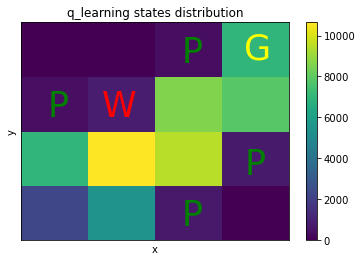

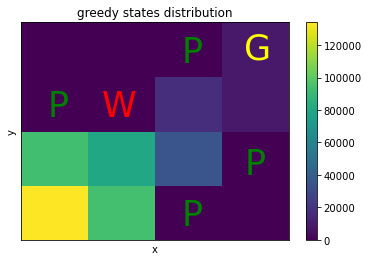

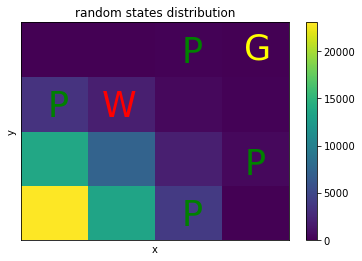

In [7]:
for algo in ["q_learning","greedy","random"]:
    ql_df = df_origin[df_origin["algo_name"]==f"{algo}"]
    plt.hist2d(ql_df["x_agent_position"], ql_df["y_agent_position"],bins=4)
    plt.text(2.5,2.5,"G", fontsize=35,color="yellow")
    plt.text(0.9,1.7,"W", fontsize=35,color="red")
    plt.text(0.3,1.7,"P", fontsize=35,color="green")
    plt.text(1.8,2.45,"P", fontsize=35,color="green")
    plt.text(2.5,0.9,"P", fontsize=35,color="green")
    plt.text(1.8,0.2,"P", fontsize=35,color="green")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{algo} states distribution")
    plt.show()

### Comments
- We generated the data ourselves.
- We used algorithms implemented by us.
- We used a preimplemented version of the wumpus world. (https://github.com/MagicTurtle2203/QLearningWumpusWorld)
- We have not added or modified the original data for the time being.
- In the follow-up process, we will filter the original data when required (drop some columns i.e.)

## Projection
Project your data into a 2D space.
Try multiple (3+) projection methods (e.g., t-SNE, UMAP, MDS, PCA, ICA, other methods) with different settings and compare them.

Make sure that all additional dependencies are included when submitting.

UMAP:

In [114]:
fn = f"data/wumpus/wumpus.csv"
df = pd.read_csv(fn)

In [115]:
df = df[df.run>=(9999-20)]
df.shape

(1216, 10)

In [116]:
proj_data1 = df.drop(columns=['algo_name', 'run_reward', 'total_reward', 'biggest_reward'])
proj_data2 = df.drop(columns=['algo_name'])

In [117]:
trans = UMAP(n_neighbors=5).fit(proj_data1)
trans.embedding_.shape
df_umap = pd.DataFrame(trans.embedding_, columns=['X','Y'])

In [ ]:
trans = UMAP(n_neighbors=5).fit(proj_data2)
trans.embedding_.shape
df_umap2 = pd.DataFrame(trans.embedding_, columns=['X','Y'])

In [119]:
df_umapco = df.copy()
df_umapco.insert(10,'umapX',df_umap['X'].values)
df_umapco.insert(11,'umapY',df_umap['Y'].values)
df_umapco2 = df.copy()
df_umapco2.insert(10,'umapX',df_umap2['X'].values)
df_umapco2.insert(11,'umapY',df_umap2['Y'].values)

In [ ]:
alt.Chart(df_umapco).mark_line(
    opacity=0.8
).encode(
    x='umapX',
    y='umapY',
    color='algo_name:N',
    order='step:Q',
    shape='reward:N'
).properties(
    width=600,
    height=600,
    title="Projected last 20 runs - without using the cumulative reward features"
).interactive()

This is the UMAP projection of the last 20 runs without using the cumulative reward features.<br>
- Red circle -1000 reward which means the game is lost. (wumpus or pits)
- Green circles are 1000 reward which indicates the win of the game (gold)
- Obvious is: greedy takes a lot more steps
- We can see that Q-Learning is trying to win, while greedy is learning not to die. --> greedy never dies.
- Random always dies (here)

<img src="data/wumpus/img/umap_without_reward.png"/>

- Which features did you use? Why?

 [step, current pos of the agent, action and reward, number of the run]
  Why? --> We wanted to see how each algorithm performed.

- Why did you choose these hyperparameters?

  --> We tried out different values (3 to 200) and actually nn=5 delivered the best results for us.
  
- Are there patterns in the global _and_ the local structure?

  --> see comments above

In [ ]:
alt.Chart(df_umapco2).mark_line(
    opacity=0.8
).encode(
    x='umapX',
    y='umapY',
    color='algo_name:N',
    order='step:Q',
    shape='reward:N'
).properties(
    width=600,
    height=600,
    title="Projected last 20 runs"
).interactive()

This is the UMAP projection of the last 20 runs using the cumulative reward features.<br>
- We can still observe the winning and dying states.
- But it is harder to find out where comonalities are.
- Also winning and dying states are not shared anymore, they are now in different clusters.
- We cannot determine where the algorithms seem to start.

<img src="data/wumpus/img/umap_withrewards.png"/>

- Which features did you use? Why?

 [step, current pos of the agent, action and reward, number of the run]
  Why? --> We wanted to see how each algorithm performed.

- Why did you choose these hyperparameters?

  --> We tried out different values (3 to 200) and actually nn=5 delivered the best results for us.
  
- Are there patterns in the global _and_ the local structure?

  --> see comments above

PCA:

In [57]:
fn = f"data/wumpus/wumpus.csv"
df = pd.read_csv(fn)
df.columns

Index(['algo_name', 'x_agent_position', 'y_agent_position', 'run', 'step',
       'action', 'reward', 'run_reward', 'total_reward', 'biggest_reward'],
      dtype='object')

In [63]:
df = df[df.run>=(9999-20)]
#df.value_counts(df.algo_name)
df.shape

(1216, 10)

In [64]:
proj_data = df.drop(columns=['algo_name', 'run_reward', 'total_reward', 'biggest_reward'])

In [65]:
pca = PCA(n_components=2).fit_transform(proj_data)
pca_df = pd.DataFrame(pca, columns=['X','Y'])

In [66]:
df_pca = df.copy()
df_pca.insert(10,'pcaX',pca_df['X'].values)
df_pca.insert(11,'pcaY',pca_df['Y'].values)

In [ ]:
alt.Chart(df_pca).mark_line(
    opacity=0.8
).encode(
    x='pcaX',
    y='pcaY',
    color='algo_name:N',
    order='step:Q',
    shape='reward:N'
).properties(
    width=600,
    height=600,
    title="Projected the last 20 runs"
).interactive()

This is the PCA downprojection of the last 20 runs without cumulative reward features.
- X axis is the same  as the actual reward.
- Y axis seems to have some correlation with the amount of steps. (maybe average steps per run)

<img src="data/wumpus/img/pca.png"/>

- Which features did you use? Why?

 [step, current pos of the agent, action and reward, number of the run]
  Why? --> We wanted to see how each algorithm performed.
  
- Are there patterns in the global _and_ the local structure?

  --> see comments above

TSNE:

In [104]:
fn = f"data/wumpus/wumpus.csv"
df = pd.read_csv(fn)

In [105]:
df.value_counts(df.algo_name)

algo_name
greedy        471283
random         70253
q_learning     61349
dtype: int64

In [106]:
df = df[df.run >= 9980] #last 20 runs
#df.value_counts(df.algo_name)
df

,algo_name,x_agent_position,y_agent_position,run,step,action,reward,run_reward,total_reward,biggest_reward
70143,random,0,0,9980,0,2,-1,-1,0,0
70144,random,0,0,9980,1,2,-1,-2,0,0
70145,random,0,0,9980,2,1,-1,-3,0,0
70146,random,0,1,9980,3,0,-1,-4,0,0
70147,random,0,1,9980,4,2,-1,-5,0,0
...,...,...,...,...,...,...,...,...,...,...
602880,q_learning,1,1,9999,1,3,-1,-2,3913656,1000
602881,q_learning,2,1,9999,2,3,-1,-3,3913656,1000
602882,q_learning,2,2,9999,3,0,-1,-4,3913656,1000
602883,q_learning,3,2,9999,4,3,-1,-5,3913656,1000


In [107]:
#data filtering
proj_data = df.drop(columns=['algo_name','run','run_reward','total_reward','biggest_reward'])
proj_data

,x_agent_position,y_agent_position,step,action,reward
70143,0,0,0,2,-1
70144,0,0,1,2,-1
70145,0,0,2,1,-1
70146,0,1,3,0,-1
70147,0,1,4,2,-1
...,...,...,...,...,...
602880,1,1,1,3,-1
602881,2,1,2,3,-1
602882,2,2,3,0,-1
602883,3,2,4,3,-1


In [108]:
tsne_coords = manifold.TSNE(perplexity=15, n_iter=250, n_jobs=10).fit_transform(proj_data)
tsne_coords.shape

(1107, 2)

In [109]:
df_tsne_coords = pd.DataFrame(tsne_coords, columns=['X','Y'])
df_tsne_coords.describe()

,X,Y
count,1107.000000,1107.000000
mean,-0.033318,0.024067
std,2.540836,3.236808
min,-5.658853,-5.267077
25%,-1.828208,-2.925067
50%,-0.000587,0.597110
75%,1.967604,2.465583
max,5.080173,7.302924


In [110]:
alt.Chart(df_tsne_coords).mark_circle(
    opacity=0.7
).encode(
    x='X',
    y='Y',
).properties(
    width=500,
    height=400,
    title="Projected Last 20 Run States"
).interactive()

alt.Chart(...)

In [111]:
df.insert(10,'tsneX',df_tsne_coords['X'].values)
df.insert(11,'tsneY',df_tsne_coords['Y'].values)
#df.loc[:, 'step']=df['run']+df['step']
df

,algo_name,x_agent_position,y_agent_position,run,step,action,reward,run_reward,total_reward,biggest_reward,tsneX,tsneY
70143,random,0,0,9980,0,2,-1,-1,0,0,-3.498351,2.504544
70144,random,0,0,9980,1,2,-1,-2,0,0,-3.254391,2.483817
70145,random,0,0,9980,2,1,-1,-3,0,0,-2.836549,2.230554
70146,random,0,1,9980,3,0,-1,-4,0,0,-2.281240,1.678569
70147,random,0,1,9980,4,2,-1,-5,0,0,-1.768908,2.759917
...,...,...,...,...,...,...,...,...,...,...,...,...
602880,q_learning,1,1,9999,1,3,-1,-2,3913656,1000,-4.841328,3.947307
602881,q_learning,2,1,9999,2,3,-1,-3,3913656,1000,-4.324216,4.628421
602882,q_learning,2,2,9999,3,0,-1,-4,3913656,1000,-5.562850,-1.776566
602883,q_learning,3,2,9999,4,3,-1,-5,3913656,1000,-0.917846,4.386389


In [ ]:
alt.Chart(df).mark_line(
    opacity=0.6
).encode(
    x='tsneX',
    y='tsneY',
    color='algo_name:N',
    shape='reward:N',
    order='step:Q'
).properties(
    width=600,
    height=600,
    title="Projected Last 20 Run States"
).interactive()

This is the TSNE downprojection using the last 20 states without cumulative reward and without the run number
- Red circle is the dying states
- Orange circles are the Q-Learning states that lead to death
- Green cricle is the winning states
- Black circle is the starting point/area
- We can observe very similar things as in the UMAP plot
- Random dies fast.
- Q-Learning wins or dies fast.
- Greedy takes its time exploring and never dies.

<img src="data/wumpus/img/tsne.png"/>

- Which features did you use? Why?

 [step, current pos of the agent, action and reward]
  Why? --> We wanted to see how each algorithm performed.

- Why did you choose these hyperparameters?

  --> perplexity=15, n_iter=250. because delivered good results.
  
- Are there patterns in the global _and_ the local structure?

  --> see comments above

### Link States
Connect the states that belong together.

The states of a single solution should be connected to see the path from the start to the end state.
How the points are connected is up to you, for example, with straight lines or splines.


We did this part already combined with the first one.

### Meta Data Encoding 
Encode addtional features in the visualization.

Use features of the source data and include them in the projection, e.g., by using color, opacity, different shapes or line styles, etc.

We did this part already combined with the first one.

### Interpretion
- What can be seen in the projection(s)?
- Was it what you expected? If not what did you expect?
- Can you confirm prior hypotheses from the projection?
- Did you get any unexpected insights?


In the beginning we expected that each algorithm will perform differently.
And we clearly saw that in both TSEN and UMAP.

So what did we see:
- the starting states
- the winning states
- where they died
- how greedy explored the space differently than the other two

## Submission
When you’ve finished working on this assignment please download this notebook as HTML and add it to your repository in addition to the notebook file.